In [56]:
from itertools import combinations, zip_longest
import wellmap
import pickle

# Functions
Define some functions needed to set up the well arrangement

In [1]:
def find(tp, a):
    """Get the position in tuple tp of value a"""
    for i, x in enumerate(tp):
        if x == a:
            return i


def n_clusters(iterable, n=2, fillvalue=None):
    """For clusters of size n, get the non overlapping cluster membership.
    For example [1, 2, 3, 4] returns [(1, 2), (3, 4)]"""
    return zip_longest(*[iter(iterable)]*n, fillvalue=fillvalue)

# Experiment specific information
Here we need to set some variables related to the experiment. For example, the set of species that
will be used.

In [3]:
# the species used in the experiment
species_names = ['OP50', 'anc_1287', 'anc_1977', 'evo_1287', 'evo_1977']
# numerical indexes for species
species = list(range(0, 5))
# generate all possible unique pairwise combinations of the species
combos = list(combinations(species, 2))
# number of plates needed, 2 combos per plate
no_plates = round(len(combos)/2)
# column pairings for the 12-well plates. Each 12-well plate holds 2 treatments
# with 6 replicates divided between the first and last 2 columns of the plate
cols = ((0, 1), (2, 3))

Make the nested data structure holding information about which species go on which plates, in which
columns, and in which orientation. Remember all of this is zero indexed so when you actually are
thinking about the plate you need to add 1 to all integers. This dictionary is arranged with the
first key (below 0) as the species identifier which depends on the order of species in the variable
species_names above. Next, a dictionary with keys of the species combinations that that parent
species is combined with - for example, `(0,1)` would be OP50 and anc_1287. The values for this
dictionary is a list where the first element is the columns that this species combination is in and
the second element is the plate number. This is because we are setting 12 well plates up in a 2x3
block where the first block of 6 wells is 6 replicates for one species combination and the second
block is for another species combination.

`{0: {(0, 1): [(0, 1), 0], (0, 2): [(2, 3), 0], (0, 3): [(0, 1), 1], (0, 4): [(2, 3), 1]}, ...`

In [58]:
sp_d = {}
for x in species:
    sp_d[x] = {}
    # the reason this works is that we use 2 columns and 3 rows per 12-well
    # plate to hold one species pairing (so 6 replicates per pairing).
    for i, j in enumerate(n_clusters(combos)):
        for k in [0, 1]:
            if j[k] is not None:
                if x in j[k]:
                    sp_d[x][j[k]] = [cols[k], i]

# write this as a json file to be used for the robot
with open('food_choice_mapping.pkl', 'wb') as f:
    pickle.dump(sp_d, f)              

This nested structure is necessary for the OT-2 robot to move in the most efficient way. It will
make the OT-2 spot from species by species rather than well by well. This arrangement allows it to
go faster and use fewer tips because it can aspirate one large volume for each species and then
dispense small aliquots sequentially.

This nested structure can be parsed and written into a more intuitive form in a text file.

In [48]:
outfile = open('food_choice_mapping.txt', 'w', encoding="utf-8")
outfile.write('vertical_species | horizontal_species\tplate_deck_pos\tplate_columns\n')
for sp in species:
    for pos_k, pos_v in sp_d[sp].items():
        if find(pos_k, sp) == 0:
            outfile.write('vert.'+str(species_names[pos_k[0]]) + ' | ' + 'horz.'+str(species_names[pos_k[1]]) + '\t' + str(pos_v[1]+1) + '\t' + str([x+1 for x in pos_v[0]]) + '\n')
outfile.close()

By slightly parsing this text file into a toml format you can visualize how the plates will look
using the `wellmap` package.  

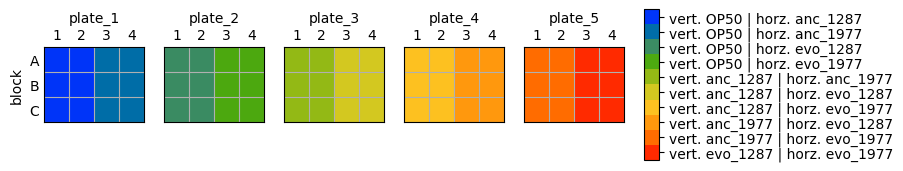

In [53]:
wellmap.show("food_choice_mapping.toml");